In [73]:
import numpy as np

datasets = np.load('npz/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

cls = []
for i in numbers:
    label = 1 if i != 0 else 0    
    cls.append(label)
cls = np.array(cls)
print(images.shape, numbers.shape, bboxes.shape, cls.shape)
print(images.max(), images.min())
print(bboxes[:3])
print(cls[999:1010])


dataset = {
    'images' : images,
    'numbers' : numbers,
    'bboxes' : bboxes,
    'cls' : cls
}

print(dataset['images'].shape)
print(dataset['numbers'].shape)
print(dataset['bboxes'].shape)
print(dataset['cls'].shape)


(13276, 24, 32, 1) (13276,) (13276, 4, 4) (13276,)
255 0
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[1 1 1 1 1 1 1 1 1 1 1]
(13276, 24, 32, 1)
(13276,)
(13276, 4, 4)
(13276,)


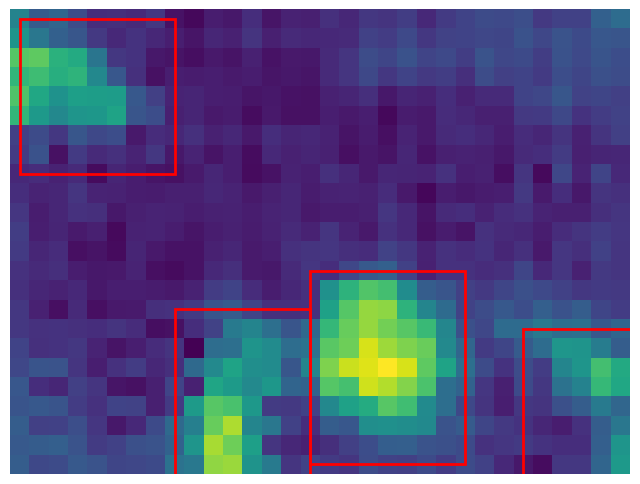

In [74]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
numbers =dataset['numbers']
bboxes = dataset['bboxes']
cls = dataset['cls']

boxes = bboxes[9000]
plt.figure(figsize = (8, 8))
plt.axis('off')
plt.imshow(images[9000])
ax = plt.gca()
boxes = tf.stack([
	boxes[:, 0] * images.shape[2],
	boxes[:, 1] * images.shape[1],
	boxes[:, 2] * images.shape[2],
	boxes[:, 3] * images.shape[1]], axis = -1
)
    

for box in boxes:
	xmin, ymin = box[:2]
	w, h = box[2:] - box[:2]
	patch = plt.Rectangle(
		[xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
	)
	ax.add_patch(patch)
plt.show()

In [75]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_TRAIN = int(images.shape[0] * 0.7)
N_VAL = images.shape[0] - N_TRAIN
LOG_DIR = 'ObjectDetectionLog'

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)
print("N_VAL:           ", N_VAL)


IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           13276
N_TRAIN:          9293
N_VAL:            3983


In [4]:
# shuffle_list = list(range(N_DATA))
# random.shuffle(shuffle_list)

# train_idx_list = shuffle_list[:N_TRAIN]
# val_idx_list = shuffle_list[N_TRAIN:]

# cur_dir = os.getcwd()
# tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
# os.makedirs(tfr_dir, exist_ok=True)

# tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
# tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

# writer_train = tf.io.TFRecordWriter(tfr_train_dir)
# writer_val = tf.io.TFRecordWriter(tfr_val_dir)


In [5]:
# def _bytes_feature(value):
#     if isinstance(value, type(tf.constant(0))):
#         value = value.numpy()
#     return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

# def _float_feature(value):
#     return tf.train.Feature(float_list = tf.train.FloatList(value = value))

# def _int64_feature(value):
#     return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

In [6]:
# for idx in train_idx_list:
#     bbox = bboxes[idx]
#     xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]

#     xmin = xmin / IMG_SIZE_WIDTH
#     ymin = ymin / IMG_SIZE_HEIGHT
#     xmax = xmax / IMG_SIZE_WIDTH
#     ymax = ymax / IMG_SIZE_HEIGHT

#     bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

#     image = images[idx]
#     bimage = image.tobytes()

#     number = numbers[idx]
#     label = 1 if number != 0 else 0    
    
#     example = tf.train.Example(features = tf.train.Features(feature = {
#         'image': _bytes_feature(bimage),
#         'bbox': _float_feature(bbox),
#         'count': _int64_feature(number),
#         'label':_int64_feature(label)
#     }))
    
#     writer_train.write(example.SerializeToString())
# writer_train.close()


In [7]:
# for idx in val_idx_list:
#     bbox = bboxes[idx]
#     xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]

#     xmin = xmin / IMG_SIZE_WIDTH
#     ymin = ymin / IMG_SIZE_HEIGHT
#     xmax = xmax / IMG_SIZE_WIDTH
#     ymax = ymax / IMG_SIZE_HEIGHT

#     bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

#     image = images[idx]
#     bimage = image.tobytes()

#     number = numbers[idx]
#     label = 1 if number != 0 else 0    
    
#     example = tf.train.Example(features = tf.train.Features(feature = {
#         'image': _bytes_feature(bimage),
#         'bbox': _float_feature(bbox),
#         'count': _int64_feature(number),
#         'label':_int64_feature(label)
#     }))
    
#     writer_val.write(example.SerializeToString())
# writer_val.close()


In [8]:
# AUTOTUNE = tf.data.AUTOTUNE

# RES_HEIGHT =24.0
# RES_WIDTH = 32.0
# N_EPOCHS = 100
# N_BATCH = 8
# LR = 0.0005


# def _parse_function(tfrecord_serialized):
#     features = {
#         'image': tf.io.FixedLenFeature([], tf.string),
#         'bbox': tf.io.VarLenFeature(tf.float32),  
#         'count': tf.io.FixedLenFeature([], tf.int64),
#         'label': tf.io.FixedLenFeature([], tf.int64)
#     }

#     parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

#     image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
#     image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
#     image = tf.cast(image, tf.float32) / 255.0

#     bbox = tf.sparse.to_dense(parsed_features['bbox']) 
#     bbox = tf.cast(bbox, tf.float32)
#     num_boxes = tf.shape(bbox)[0] // 4
#     bbox = tf.reshape(bbox, [num_boxes, 4])

#     count = tf.cast(parsed_features['count'], tf.int64)
#     label = tf.cast(parsed_features['label'], tf.int64)

#     return image, bbox, count, label


# train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
# train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
# # train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

# val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
# val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)


In [9]:
# import matplotlib.pyplot as plt

# for image, bbox, count, label in val_dataset.take(5):
#     image = image[0].numpy()
#     bbox = bbox[0]
#     count = count[0]
#     label = label[0]

#     plt.figure(figsize = (8, 8))
#     plt.axis('off')
#     plt.imshow(image)
#     ax = plt.gca()  

#     image_h = image.shape[0]    
#     image_w = image.shape[1]

#     boxes = tf.stack(
#     	[
#     	 bbox[:, 0] * image_w,
#     	 bbox[:, 1] * image_h,
#     	 bbox[:, 2] * image_w,
#     	 bbox[:, 3] * image_h
#     	], axis = -1
#     )

#     for box in boxes:
#         xmin, ymin = box[:2]
#         w, h = box[2:] - box[:2]
#         patch = plt.Rectangle(
#             [xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
#         )
#         ax.add_patch(patch)
#     plt.show()
#     print(count, label)


In [ ]:
# import matplotlib.pyplot as plt

# boxes = bboxes[9000]
# plt.figure(figsize = (8, 8))
# plt.axis('off')
# plt.imshow(images[9000])
# ax = plt.gca()

# for box in boxes:
# 	xmin, ymin = box[:2]
# 	w, h = box[2:] - box[:2]
# 	patch = plt.Rectangle(
# 		[xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
# 	)
# 	ax.add_patch(patch)
# plt.show()

# image, bbox, count, label

In [79]:
def convert_to_xywh(boxes):    
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

In [80]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

In [81]:
def resize_and_pad_image(image, ratio = 3, stride = 8):
    image_shape = tf.cast(tf.shape(image)[:2], dtype = tf.float32)
    
    image_shape = ratio * image_shape

    image = tf.image.resize(image, tf.cast(image_shape, dtype = tf.int32))

    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype = tf.int32
    )

    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )

    return image, image_shape, ratio



In [82]:
# images = dataset['images']
# numbers =dataset['numbers']
# bboxes = dataset['bboxes']
# cls = dataset['cls']

def preprocess_data(sample):
    image = sample["images"]
    bbox = sample["bboxes"]
    class_id = tf.cast(sample["cls"], dtype = tf.int32)

    image, image_shape, _ = resize_and_pad_image(image)
    bbox = tf.stack([
        bbox[:, 0] * image_shape[1],
        bbox[:, 1] * image_shape[0],
        bbox[:, 2] * image_shape[1],
        bbox[:, 3] * image_shape[0]],
        axis = -1
    )
    bbox = convert_to_xywh(bbox)

    return image, bbox, class_id
    
    

(72, 96, 1)
(72, 96, 3)


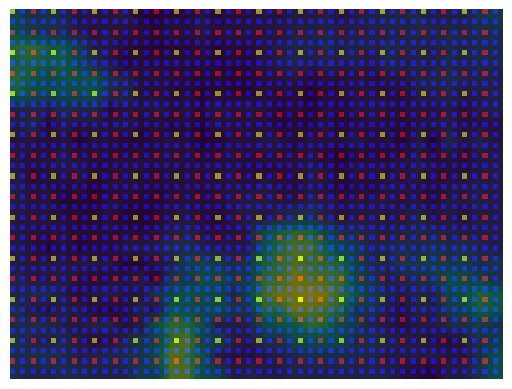

In [83]:
import numpy as np
import matplotlib.pyplot as plt
# 이미지의 크기를 줄여서 설정 (예시: 100x100)
# images = dataset['images']
# numbers = dataset['numbers']
# bboxes = dataset['bboxes']
# cls = dataset['cls']
# 이미지 생성 (흰색 배경)
img = images[9000]
num = numbers[9000]
bb = bboxes[9000]
cs = cls[9000]
sample = {
    'images' : img,
    'numbers' : num,
    'bboxes' : bb,
    'cls' : cs
}

img, _, _ = preprocess_data(sample)
print(img.shape) # (72, 96, 1)

anchor_img = np.zeros((*img.shape[:2], 3), dtype=np.uint8)
print(anchor_img.shape)

strides = [2, 4, 8]
colors = {
    # 2: [0, 255, 0],  # 초록색
    2: [0, 0, 255],  # 파란색
    4: [255, 0, 0],   # 빨간색
    8:[255, 255, 0]  # 노란색
}

for stride in strides:
    color = colors[stride]
    for y in range(0, anchor_img.shape[0], stride):
        for x in range(0, anchor_img.shape[1], stride):
            anchor_img[y, x, :] = color

# 이미지 표시
plt.imshow(img, alpha=1)  
plt.imshow(anchor_img, alpha=0.5) 
plt.axis('off')
plt.show()

In [84]:
import math
ratios = [0.5, 1.0, 2.0]
areas = [16, 64, 256]

for area in areas:
    for ratio in ratios:
        H = math.sqrt(area / ratio)
        W = area / H
        print(f'Area: {area}')
        print(f'Ratio: {ratio}')
        print(f'Height: {H}\nWidth: {W}\n')
    

Area: 16
Ratio: 0.5
Height: 5.656854249492381
Width: 2.82842712474619

Area: 16
Ratio: 1.0
Height: 4.0
Width: 4.0

Area: 16
Ratio: 2.0
Height: 2.8284271247461903
Width: 5.65685424949238

Area: 64
Ratio: 0.5
Height: 11.313708498984761
Width: 5.65685424949238

Area: 64
Ratio: 1.0
Height: 8.0
Width: 8.0

Area: 64
Ratio: 2.0
Height: 5.656854249492381
Width: 11.31370849898476

Area: 256
Ratio: 0.5
Height: 22.627416997969522
Width: 11.31370849898476

Area: 256
Ratio: 1.0
Height: 16.0
Width: 16.0

Area: 256
Ratio: 2.0
Height: 11.313708498984761
Width: 22.62741699796952



dataset = {
    'images' : images,
    'numbers' : numbers,
    'bboxes' : bboxes,
    'cls' : cls
}

In [85]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        print('self.aspect_ratios: ', self.aspect_ratios)
        
        self.scales = [2** x for x in [0, 1/3, 2/3]]
        print('self.scales: ', self.scales)
        
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        print(' self._num_anchors: ',  self._num_anchors)
        
        self._strides = [2 ** i for i in range(1, 4)]
        print('self._strides: ', self._strides)
        
        self._areas = [x ** 2 for x in [4, 8, 16]]
        print('self._areas: ', self._areas)

        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []

        for area in self._areas:
            anchor_dims = []

            for ratio in self.aspect_ratios: 
                print(f'\narea: {area}  ratio: {ratio}')
                
                anchor_height = tf.math.sqrt(area / ratio)
                print(f'anchor_height: {anchor_height}')

                anchor_width = area / anchor_height
                print(f'anchor_width: {anchor_width}')
                
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                print(f"dims: {dims.numpy()}")
                
                for scale in self.scales: 
                    anchor_dims.append(scale * dims) 
                    print(f"scales: {scale}")
                    print(f"anchor_dims: {anchor_dims}\n")
            
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        
        print(f"anchor_dims_all: {anchor_dims_all}")
        return anchor_dims_all 
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        print(f"rx: {rx}")

        ry = tf.range(feature_height, dtype = tf.float32) + 0.5
        print(f"ry: {ry}")

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level -1]
        print(f"centers: {centers}")
        centers = tf.expand_dims(centers, axis = -2)
        print(f"centers: {centers}")
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        print(f"centers: {centers}")

        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1] 
        )
        print(f"dims: {dims}")
        anchors = tf.concat([centers, dims], axis=-1) 
        print(f"anchors: {anchors}")

        print(f"{tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4]).shape}")
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(1, 4)
        ]
        print(tf.concat(anchors, axis=0))
        return tf.concat(anchors, axis=0)

In [86]:
anchors = AnchorBox()
anchor = anchors.get_anchors(72, 96)

self.aspect_ratios:  [0.5, 1.0, 2.0]
self.scales:  [1, 1.2599210498948732, 1.5874010519681994]
 self._num_anchors:  9
self._strides:  [2, 4, 8]
self._areas:  [16, 64, 256]

area: 16  ratio: 0.5
anchor_height: 5.656854152679443
anchor_width: 2.8284270763397217
dims: [[[2.828427 5.656854]]]
scales: 1
anchor_dims: [<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[2.828427, 5.656854]]], dtype=float32)>]

scales: 1.2599210498948732
anchor_dims: [<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[2.828427, 5.656854]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[3.5635948, 7.1271896]]], dtype=float32)>]

scales: 1.5874010519681994
anchor_dims: [<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[2.828427, 5.656854]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[3.5635948, 7.1271896]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[4.489848, 8.979696]]], dtype=float32)>]


ar

(20412, 4)


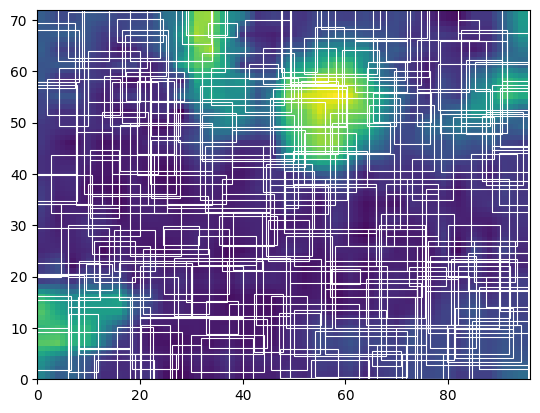

In [21]:
print(anchor.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 96)
    ax.set_ylim(0, 72)

    ax.imshow(img)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np

    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(anchor, 200)


In [103]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.maximum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(rd - lu, 0.0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [104]:
# b1 = np.array([])
b1 = np.array([[92, 68, 8.979696, 4.489848]])
b2 = np.array([[0.25, 0, 0.46875, 0.8125 ]])
result = compute_iou(b1, b2)
print(result)

tf.Tensor([[1.]], shape=(1, 1), dtype=float64)
